# SGR LAOS: Nonlinear Oscillatory Response of Soft Glasses

**Learning Objectives:**
- Generate large-amplitude oscillatory shear (LAOS) waveforms
- Plot elastic and viscous Lissajous-Bowditch curves
- Extract Fourier harmonics (I₁, I₃, I₅) and compute nonlinearity ratios
- Compute Chebyshev coefficients (e₁, e₃, v₁, v₃) for elastic/viscous nonlinearity
- Understand strain stiffening/softening and shear thickening/thinning
- Explore phase regime effects on LAOS response

**Prerequisites:**
- Notebook 01 (calibrated emulsion parameters)
- `examples/basic/01_oscillation_fitting.ipynb`

**Runtime:**
- Fast mode: ~3 min
- Full mode: ~8 min

**Note:** SGRGeneric does not support LAOS `model_function()` — this notebook uses SGRConventional only.

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: LAOS Analysis

In **large-amplitude oscillatory shear (LAOS)**, the applied strain is:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$

where $\gamma_0$ is large enough that the stress response becomes nonlinear:

$$\sigma(t) = \sum_{n=1,3,5,\ldots} \left[ \sigma_n' \sin(n\omega t) + \sigma_n'' \cos(n\omega t) \right]$$

### Three Analysis Frameworks:

#### 1. Fourier Harmonics
- **First harmonic** $I_1 = \sqrt{(\sigma_1')^2 + (\sigma_1'')^2}$ — linear response
- **Third harmonic** $I_3$ — first nonlinear contribution
- **Nonlinearity ratio** $I_3/I_1$ quantifies deviation from linearity

#### 2. Lissajous-Bowditch Curves
- **Elastic Lissajous**: $\sigma$ vs $\gamma$ — encodes strain-dependent modulus
- **Viscous Lissajous**: $\sigma$ vs $\dot{\gamma}$ — encodes rate-dependent viscosity
- Shape distortion from ellipse indicates nonlinearity type

#### 3. Chebyshev Decomposition
Separates elastic and viscous contributions:
- **Elastic coefficients** $e_n$ from $\sigma$ vs $\gamma$
- **Viscous coefficients** $v_n$ from $\sigma$ vs $\dot{\gamma}$
- **Strain stiffening**: $e_3/e_1 > 0$, **strain softening**: $e_3/e_1 < 0$
- **Shear thickening**: $v_3/v_1 > 0$, **shear thinning**: $v_3/v_1 < 0$

## 3. Generate LAOS Data

In [3]:
# Load calibrated parameters from NB 01 or use defaults
params_path = os.path.join("..", "outputs", "sgr", "flow_curve", "nlsq_params.json")
if os.path.exists(params_path):
    with open(params_path) as f:
        calib_params = json.load(f)
    print(f"Loaded calibrated parameters from NB 01: {calib_params}")
else:
    calib_params = {"x": 1.3, "G0": 500.0, "tau0": 1e-3}
    print(f"Using default parameters (run NB 01 first): {calib_params}")

# Initialize model with calibrated parameters
model = SGRConventional()
for name, val in calib_params.items():
    model.parameters.set_value(name, val)
model.fitted_ = True
model._test_mode = "oscillation"

print(f"Phase regime: {model.get_phase_regime()}")

Loaded calibrated parameters from NB 01: {'x': 1.0164641594061137, 'G0': 33.70749398407571, 'tau0': 16.480806500813653}
Phase regime: power-law


In [4]:
# Simulate LAOS at 4 strain amplitudes
gamma_0_values = [0.01, 0.1, 0.5, 2.0]
omega = 1.0  # rad/s
n_cycles = 2
n_points_per_cycle = 256

laos_data = {}
for g0 in gamma_0_values:
    strain, stress = model.simulate_laos(
        g0, omega, n_cycles=n_cycles, n_points_per_cycle=n_points_per_cycle
    )
    laos_data[g0] = {"strain": np.array(strain), "stress": np.array(stress)}
    print(f"γ₀={g0:5.2f}: σ_max={np.max(np.abs(stress)):.2f} Pa, {len(strain)} points")

γ₀= 0.01: σ_max=0.26 Pa, 512 points
γ₀= 0.10: σ_max=2.63 Pa, 512 points
γ₀= 0.50: σ_max=12.04 Pa, 512 points
γ₀= 2.00: σ_max=48.16 Pa, 512 points


## 4. Lissajous-Bowditch Curves

### 4.1 Elastic Lissajous (σ vs γ)

The elastic Lissajous curve plots stress against strain. In the linear regime, this is an ellipse. Nonlinearity causes characteristic distortions that reveal the material's strain-dependent elastic response.

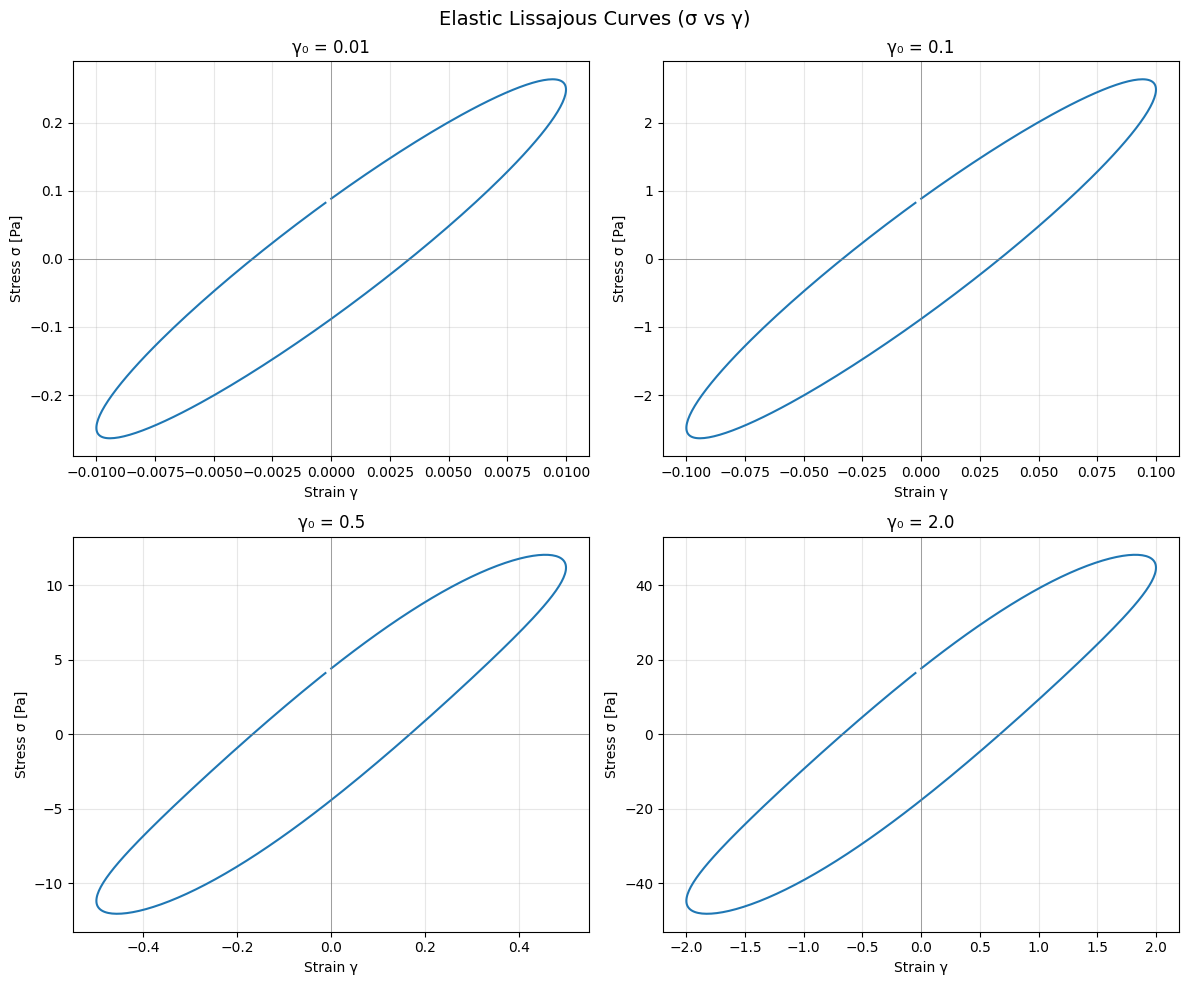

In [5]:
# Elastic Lissajous curves for all amplitudes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, g0 in enumerate(gamma_0_values):
    d = laos_data[g0]
    # Use last cycle for steady state
    n_pts = n_points_per_cycle
    strain_cycle = d["strain"][-n_pts:]
    stress_cycle = d["stress"][-n_pts:]
    
    axes[i].plot(strain_cycle, stress_cycle, "-", lw=1.5, color="C0")
    axes[i].set_xlabel("Strain γ")
    axes[i].set_ylabel("Stress σ [Pa]")
    axes[i].set_title(f"γ₀ = {g0}")
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0, color="gray", lw=0.5)
    axes[i].axvline(0, color="gray", lw=0.5)

fig.suptitle("Elastic Lissajous Curves (σ vs γ)", fontsize=14)
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Viscous Lissajous (σ vs γ̇)

The viscous Lissajous curve plots stress against strain rate. This reveals the material's rate-dependent viscous response and distinguishes shear thinning from shear thickening behavior.

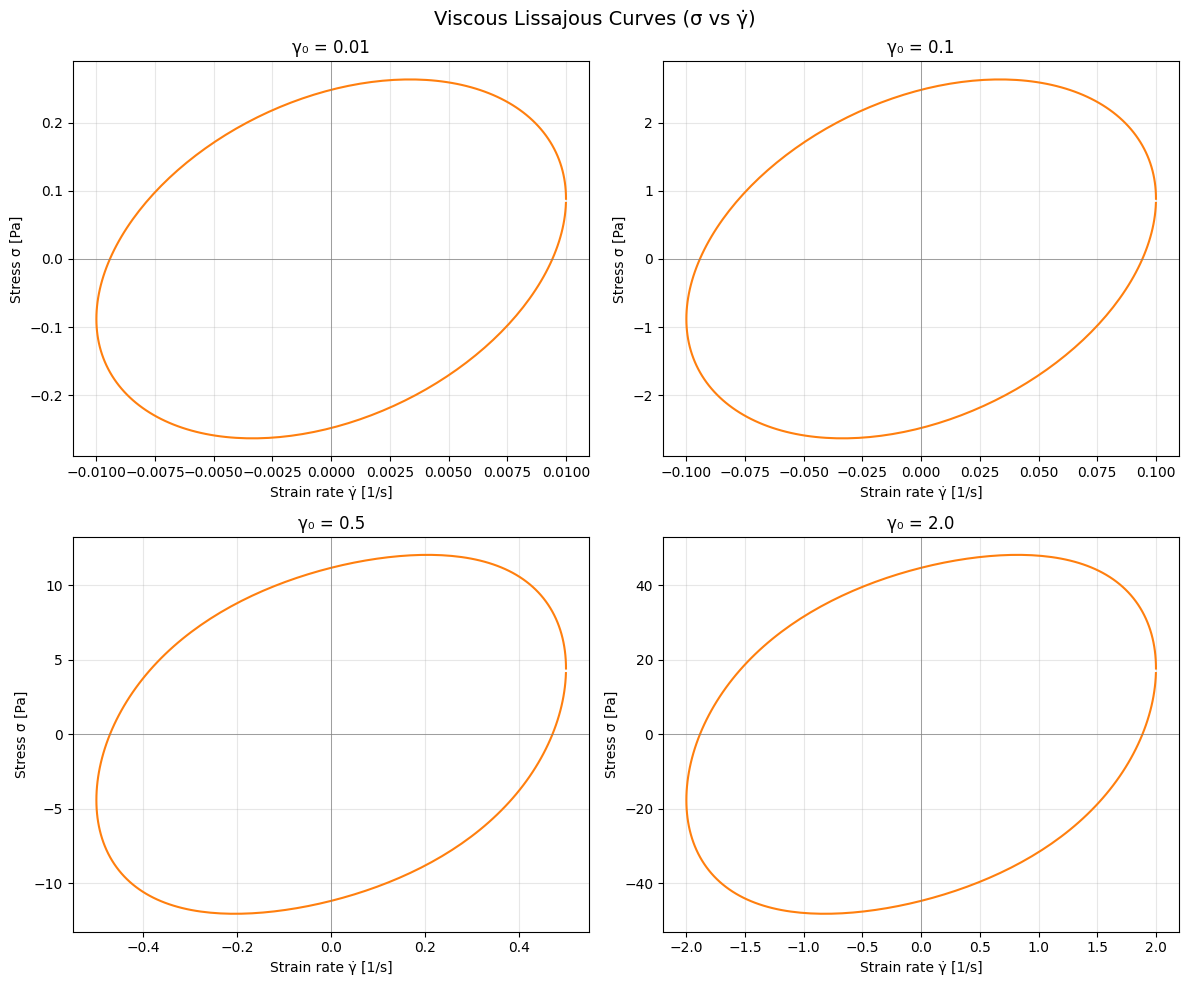

In [6]:
# Viscous Lissajous curves for all amplitudes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, g0 in enumerate(gamma_0_values):
    d = laos_data[g0]
    n_pts = n_points_per_cycle
    strain_cycle = d["strain"][-n_pts:]
    stress_cycle = d["stress"][-n_pts:]
    
    # Compute strain rate
    t_cycle = np.linspace(0, 2 * np.pi / omega, n_pts, endpoint=False)
    gamma_dot_cycle = g0 * omega * np.cos(omega * t_cycle)
    
    axes[i].plot(gamma_dot_cycle, stress_cycle, "-", lw=1.5, color="C1")
    axes[i].set_xlabel("Strain rate γ̇ [1/s]")
    axes[i].set_ylabel("Stress σ [Pa]")
    axes[i].set_title(f"γ₀ = {g0}")
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0, color="gray", lw=0.5)
    axes[i].axvline(0, color="gray", lw=0.5)

fig.suptitle("Viscous Lissajous Curves (σ vs γ̇)", fontsize=14)
plt.tight_layout()
display(fig)
plt.close(fig)

At small γ₀, the Lissajous curves are elliptical (linear viscoelastic response). As γ₀ increases, they distort — the specific shape encodes the type and degree of nonlinearity (stiffening vs softening, thickening vs thinning).

### 4.3 Normalized Lissajous via get_lissajous_curve()

Normalized Lissajous curves (γ/γ₀ vs σ/σ_max) allow direct comparison of nonlinearity across different strain amplitudes.

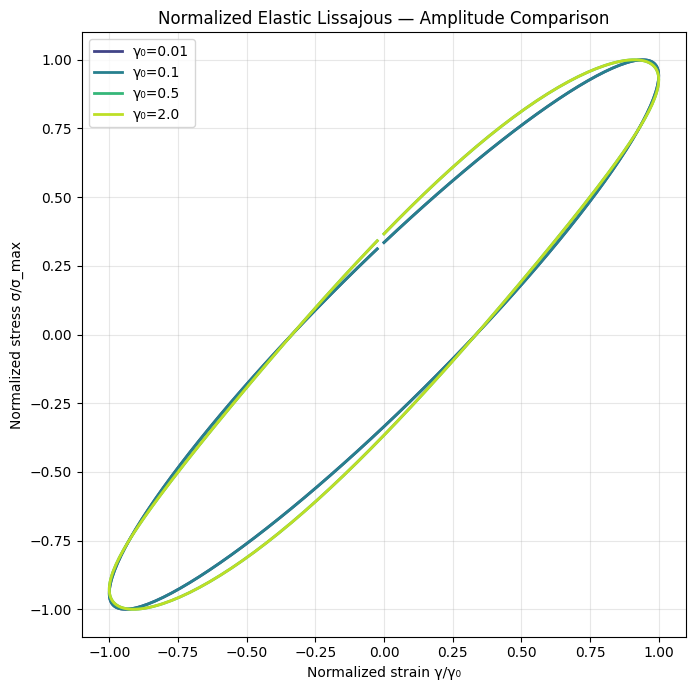

In [7]:
# Normalized Lissajous overlay
fig, ax = plt.subplots(figsize=(8, 7))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gamma_0_values)))

for i, g0 in enumerate(gamma_0_values):
    strain_n, stress_n = model.get_lissajous_curve(
        g0, omega, n_points=256, normalized=True
    )
    ax.plot(
        np.array(strain_n), np.array(stress_n), "-", 
        color=colors[i], lw=2, label=f"γ₀={g0}"
    )

ax.set_xlabel("Normalized strain γ/γ₀")
ax.set_ylabel("Normalized stress σ/σ_max")
ax.set_title("Normalized Elastic Lissajous — Amplitude Comparison")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect("equal")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Fourier Harmonic Analysis

Fourier decomposition quantifies the nonlinearity through higher harmonic contributions. The ratio $I_3/I_1$ is a common measure of nonlinearity onset.

In [8]:
# Extract harmonics for each amplitude
print("Fourier Harmonic Analysis")
print("=" * 70)
print(f"{'γ₀':>6s}  {'I₁':>10s}  {'I₃':>10s}  {'I₅':>10s}  {'I₃/I₁':>10s}  {'I₅/I₁':>10s}")
print("-" * 70)

harmonic_results = {}
for g0 in gamma_0_values:
    d = laos_data[g0]
    harmonics = model.extract_laos_harmonics(
        d["stress"], n_points_per_cycle=n_points_per_cycle
    )
    harmonic_results[g0] = harmonics
    print(
        f"{g0:6.2f}  {harmonics['I_1']:10.4f}  {harmonics['I_3']:10.4f}  "
        f"{harmonics['I_5']:10.4f}  {harmonics['I_3_I_1']:10.6f}  {harmonics['I_5_I_1']:10.6f}"
    )

Fourier Harmonic Analysis
    γ₀          I₁          I₃          I₅       I₃/I₁       I₅/I₁
----------------------------------------------------------------------
  0.01      0.2635      0.0000      0.0000    0.000000    0.000000
  0.10      2.6349      0.0000      0.0000    0.000000    0.000000
  0.50     12.2623      0.3294      0.0000    0.026860    0.000000
  2.00     49.0493      1.3175      0.0000    0.026860    0.000000


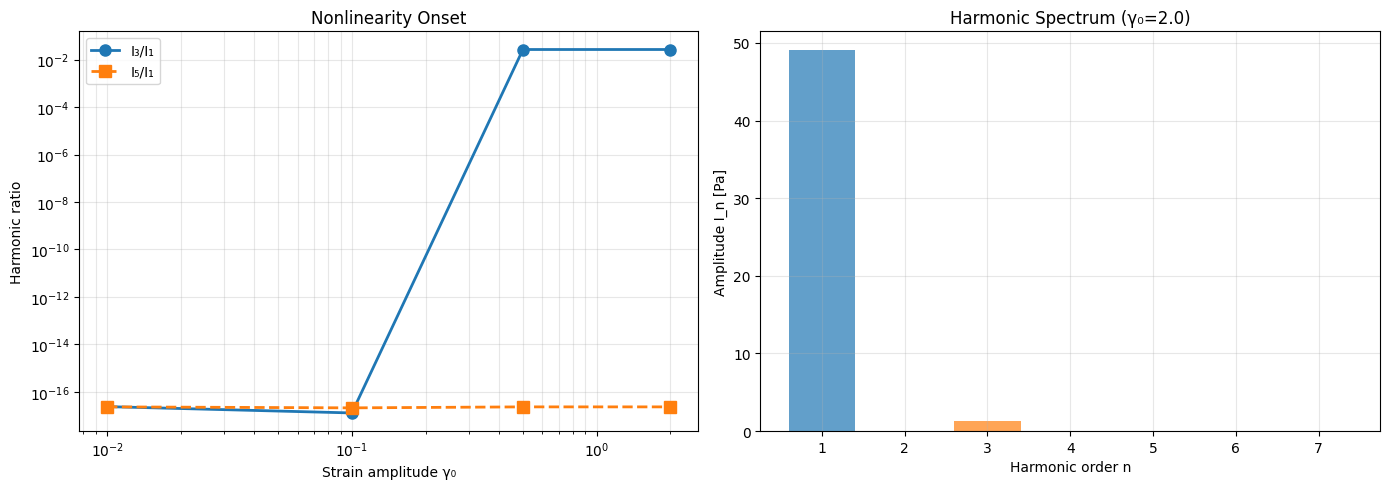

In [9]:
# Plot nonlinearity ratios and harmonic spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

g0_arr = np.array(gamma_0_values)
I3_I1 = np.array([harmonic_results[g0]["I_3_I_1"] for g0 in gamma_0_values])
I5_I1 = np.array([harmonic_results[g0]["I_5_I_1"] for g0 in gamma_0_values])

# Nonlinearity onset
ax1.loglog(g0_arr, I3_I1, "o-", markersize=8, lw=2, label="I₃/I₁")
ax1.loglog(g0_arr, I5_I1, "s--", markersize=8, lw=2, label="I₅/I₁")
ax1.set_xlabel("Strain amplitude γ₀")
ax1.set_ylabel("Harmonic ratio")
ax1.set_title("Nonlinearity Onset")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Harmonic spectrum at largest amplitude
g0_max = gamma_0_values[-1]
h = harmonic_results[g0_max]
harmonics_list = [h["I_1"], h["I_3"], h["I_5"], h.get("I_7", 0)]
ax2.bar([1, 3, 5, 7], harmonics_list, color=["C0", "C1", "C2", "C3"], alpha=0.7)
ax2.set_xlabel("Harmonic order n")
ax2.set_ylabel("Amplitude I_n [Pa]")
ax2.set_title(f"Harmonic Spectrum (γ₀={g0_max})")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Chebyshev Decomposition

Chebyshev decomposition separates elastic and viscous nonlinearities, providing a more nuanced view than Fourier analysis alone.

In [10]:
# Compute Chebyshev coefficients
print("Chebyshev Decomposition")
print("=" * 80)
print(f"{'γ₀':>6s}  {'e₁':>8s}  {'e₃':>8s}  {'v₁':>8s}  {'v₃':>8s}  {'e₃/e₁':>10s}  {'v₃/v₁':>10s}")
print("-" * 80)

cheby_results = {}
for g0 in gamma_0_values:
    d = laos_data[g0]
    cheby = model.compute_chebyshev_coefficients(
        d["strain"], d["stress"], g0, omega, n_points_per_cycle=n_points_per_cycle
    )
    cheby_results[g0] = cheby
    print(
        f"{g0:6.2f}  {cheby['e_1']:8.2f}  {cheby['e_3']:8.4f}  "
        f"{cheby['v_1']:8.2f}  {cheby['v_3']:8.4f}  "
        f"{cheby['e_3_e_1']:10.6f}  {cheby['v_3_v_1']:10.6f}"
    )

Chebyshev Decomposition
    γ₀        e₁        e₃        v₁        v₃       e₃/e₁       v₃/v₁
--------------------------------------------------------------------------------
  0.01      0.25    0.0000      0.09   -0.0001    0.000000   -0.000622
  0.10      2.48    0.0000      0.88   -0.0005    0.000000   -0.000622
  0.50     11.48   -0.3103      4.30    0.1076   -0.027027    0.025013
  2.00     45.93   -1.2414     17.21    0.4305   -0.027027    0.025013


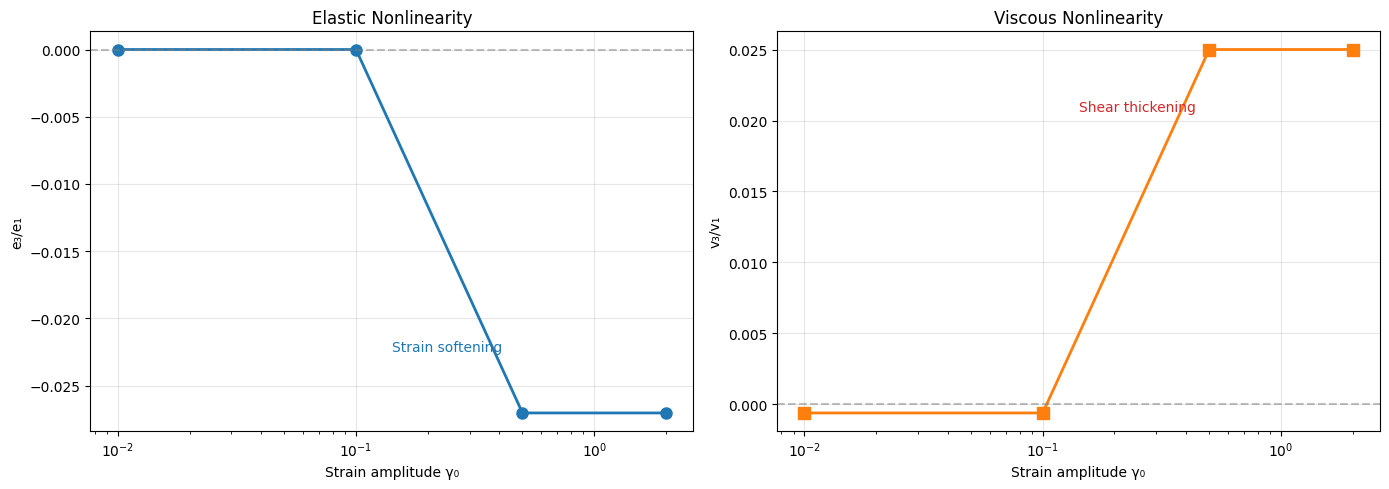

In [11]:
# Plot Chebyshev ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

g0_arr = np.array(gamma_0_values)
e3_e1 = np.array([cheby_results[g0]["e_3_e_1"] for g0 in gamma_0_values])
v3_v1 = np.array([cheby_results[g0]["v_3_v_1"] for g0 in gamma_0_values])

# Elastic nonlinearity
ax1.semilogx(g0_arr, e3_e1, "o-", markersize=8, lw=2, color="C0")
ax1.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax1.set_xlabel("Strain amplitude γ₀")
ax1.set_ylabel("e₃/e₁")
ax1.set_title("Elastic Nonlinearity")
ax1.grid(True, alpha=0.3)

# Annotate stiffening/softening
if e3_e1[-1] > 0:
    ax1.annotate(
        "Strain stiffening", xy=(0.5, 0.8), xycoords="axes fraction", 
        fontsize=10, color="C3"
    )
else:
    ax1.annotate(
        "Strain softening", xy=(0.5, 0.2), xycoords="axes fraction", 
        fontsize=10, color="C0"
    )

# Viscous nonlinearity
ax2.semilogx(g0_arr, v3_v1, "s-", markersize=8, lw=2, color="C1")
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Strain amplitude γ₀")
ax2.set_ylabel("v₃/v₁")
ax2.set_title("Viscous Nonlinearity")
ax2.grid(True, alpha=0.3)

# Annotate thickening/thinning
if v3_v1[-1] > 0:
    ax2.annotate(
        "Shear thickening", xy=(0.5, 0.8), xycoords="axes fraction", 
        fontsize=10, color="C3"
    )
else:
    ax2.annotate(
        "Shear thinning", xy=(0.5, 0.2), xycoords="axes fraction", 
        fontsize=10, color="C0"
    )

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Phase Regime Effect on LAOS

The noise temperature parameter $x$ controls the phase regime (glass, power-law fluid, Newtonian) and dramatically affects the LAOS response. Let's compare Lissajous curves for different $x$ values at fixed $\gamma_0$.

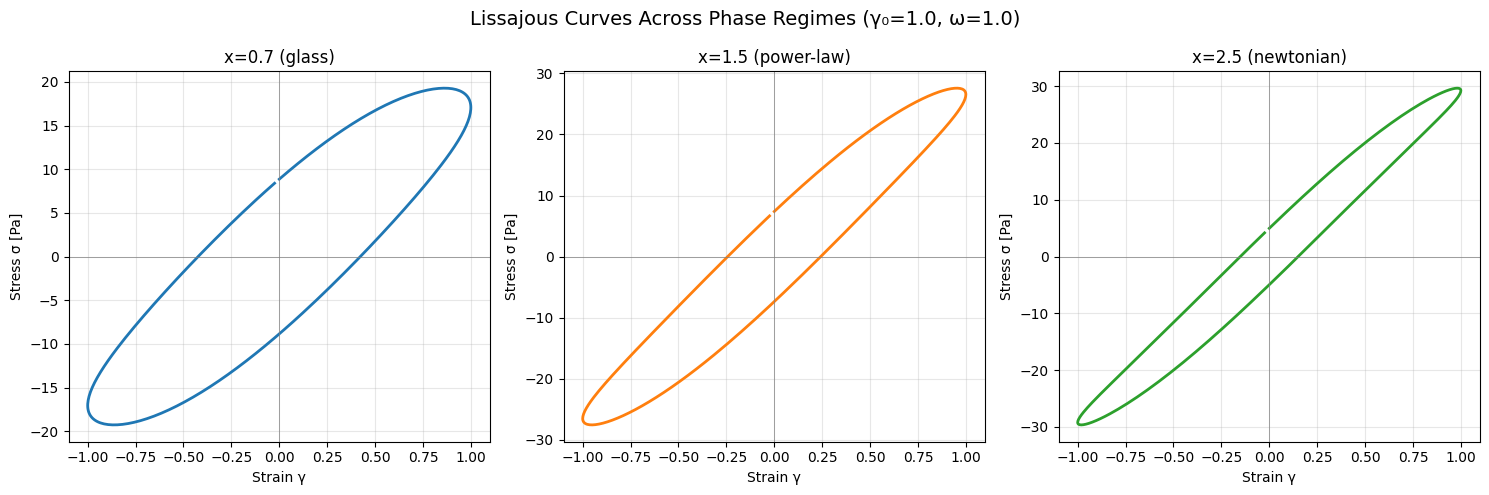

In [12]:
# Compare Lissajous curves across phase regimes
x_values = [0.7, 1.5, 2.5]
g0_compare = 1.0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", calib_params["G0"])
    m.parameters.set_value("tau0", calib_params["tau0"])
    m.fitted_ = True
    m._test_mode = "oscillation"

    strain_c, stress_c = m.get_lissajous_curve(g0_compare, omega, n_points=256)
    regime = m.get_phase_regime()

    axes[i].plot(np.array(strain_c), np.array(stress_c), "-", lw=2, color=f"C{i}")
    axes[i].set_xlabel("Strain γ")
    axes[i].set_ylabel("Stress σ [Pa]")
    axes[i].set_title(f"x={x_val} ({regime})")
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0, color="gray", lw=0.5)
    axes[i].axvline(0, color="gray", lw=0.5)

fig.suptitle(
    f"Lissajous Curves Across Phase Regimes (γ₀={g0_compare}, ω={omega})", 
    fontsize=14
)
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [13]:
# Save harmonic and Chebyshev results
output_dir = os.path.join("..", "outputs", "sgr", "laos")
os.makedirs(output_dir, exist_ok=True)

# Save harmonic results
with open(os.path.join(output_dir, "harmonic_results.json"), "w") as f:
    json.dump({str(k): v for k, v in harmonic_results.items()}, f, indent=2)

# Save Chebyshev results
with open(os.path.join(output_dir, "chebyshev_results.json"), "w") as f:
    json.dump({str(k): v for k, v in cheby_results.items()}, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  harmonic_results.json: {len(harmonic_results)} amplitudes")
print(f"  chebyshev_results.json: {len(cheby_results)} amplitudes")

Results saved to ../outputs/sgr/laos/
  harmonic_results.json: 4 amplitudes
  chebyshev_results.json: 4 amplitudes


## Key Takeaways

1. **LAOS reveals nonlinear behavior** hidden in small-amplitude (SAOS) tests — Lissajous distortion quantifies material nonlinearity

2. **Fourier harmonics** ($I_3/I_1$, $I_5/I_1$) measure overall nonlinearity onset and strength

3. **Chebyshev decomposition** separates elastic ($e_n$) and viscous ($v_n$) nonlinearity contributions

4. **Elastic nonlinearity**:
   - $e_3/e_1 > 0$ → strain stiffening (modulus increases with strain)
   - $e_3/e_1 < 0$ → strain softening (modulus decreases with strain)

5. **Viscous nonlinearity**:
   - $v_3/v_1 > 0$ → shear thickening (viscosity increases with rate)
   - $v_3/v_1 < 0$ → shear thinning (viscosity decreases with rate)

6. **Phase regime** ($x$ parameter) controls Lissajous shape:
   - Glass ($x < 1$) → more rectangular, strain softening
   - Power-law fluid ($1 < x < 2$) → intermediate distortion
   - Newtonian ($x \geq 2$) → elliptical, minimal nonlinearity

7. **SGRGeneric limitation**: Does not support LAOS `model_function()` — use SGRConventional for LAOS analysis

8. **Bayesian inference on LAOS** is computationally intensive (long time series, multiple harmonics) — omitted here for efficiency. For Bayesian analysis, consider SAOS (Notebook 02) or flow curves (Notebook 01).